In [2]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
from get_utils import get_data, get_dir
import numpy as np
import torch as th
import plot as plot
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from tdr import build_tdr, orth_wrt_map
import scipy.stats as stats

In [10]:
# Load hidden
#folder_name = 'Sim_simple3'
folder_name = 'Sim_simple'

loss_type = 'lateral'
is_channel = False
T = pd.DataFrame()

N_idx = 15 # 16
F_idx = 24 # 25

for N_idx in range(0,30,2):
    for mn in range(0,20):
        model_name = "model{:02d}".format(mn)

        # 0. load muscle space
        n_muscle = 6
        weight_file,_,_= get_dir(folder_name,model_name,'NF1',0)
        W = th.load(weight_file)['fc.weight'].numpy()
        _, _, Vh = np.linalg.svd(W, full_matrices=True)
        V = Vh.T
        P = V[:,:n_muscle] # output potent:  neurons x n_muscle
        #N = V[:,n_muscle:].T # output null space: ...x neurons

        # 1. Load data
        U = get_data(folder_name,model_name,{'NF1':[0],'FF1':[8],'NF2':[0],'FF2':[8]},[0,8,0,8]) # ,batch_size=300,catch_trial_perc=0,condition='train',go_cue_random=False,seed=seed
        data = []
        force = []
        for i in range(len(U)):
            data.append(np.array(U[i]['all_hidden'])[:,N_idx,:])
            force.append(np.array(U[i]['endpoint_force'])[:,F_idx,:])
        
        # 1.1 build TDR
        combined_N = np.vstack(data)
        mean_N = np.mean(combined_N, axis=0)

        X = force[0] # NF1 force 
        N = data[0]-mean_N # NF1 hidden activity

        tdr = build_tdr(X,N)


        # 2.2 uniform shift from NF1 to FF1
        us = np.mean(data[1]-data[0],axis=0).reshape(-1,1)
        us_orth_norm = orth_wrt_map(us,tdr) 
        #us_orth_norm = orth_wrt_map(us,P) # hear i want to try something different


        # 3. perturb hidden
        d_hidden = th.from_numpy(us_orth_norm.T*2) # 0.6

        # now lets perturb or not and calculate the saving in behavior
        data_p, loss_p = get_data(folder_name,model_name,{'NF2':[0]},[8],
                                is_channel=is_channel,disturb_hidden=True,t_disturb_hidden=N_idx/100,d_hidden=d_hidden,return_loss=True,batch=[None]) # ,batch=[3000] batch=None

        data_np, loss_np = get_data(folder_name,model_name,{'NF1':[0],'NF2':[0]},[8,8],
                                    is_channel=is_channel,return_loss=True,batch=[None,None]) #,batch=[None,3000] [None,None]
        

        loss_ff1 = loss_np[0][loss_type].item()
        loss_ff2_np = loss_np[1][loss_type].item()
        loss_ff2_p = loss_p[0][loss_type].item()

        d = {'N':[N_idx]*3,'m':[mn]*3,'loss':[loss_ff1,loss_ff2_np,loss_ff2_p],'phase':['ff1','ff2','ff2_p']}
        T = pd.concat([T,pd.DataFrame(d)],ignore_index=True)

        
        # # plot
        # n_fig = 1
        # fig,ax = plt.subplots(1,n_fig,figsize=(7*n_fig,5))
        # ax = [ax]

        # plot.plot_simulations(ax[0],xy=data_np[1]['xy'],target_xy=data_np[1]['tg'],vel=None,plot_lat=False)
        # plot.plot_simulations(ax[0],xy=data_p[0]['xy'],target_xy=data_p[0]['tg'],vel=None,plot_lat=False,cmap='plasma')

        # fig, ax = plot.plot_activation(data_p[0]['all_hidden'],data_p[0]['all_muscle']-data_np[1]['all_muscle'],figsize=(15,15))

        # #fig, ax = plot.plot_force([data_np[1],data_p[0]],['np','p'],figsize=(10,15))

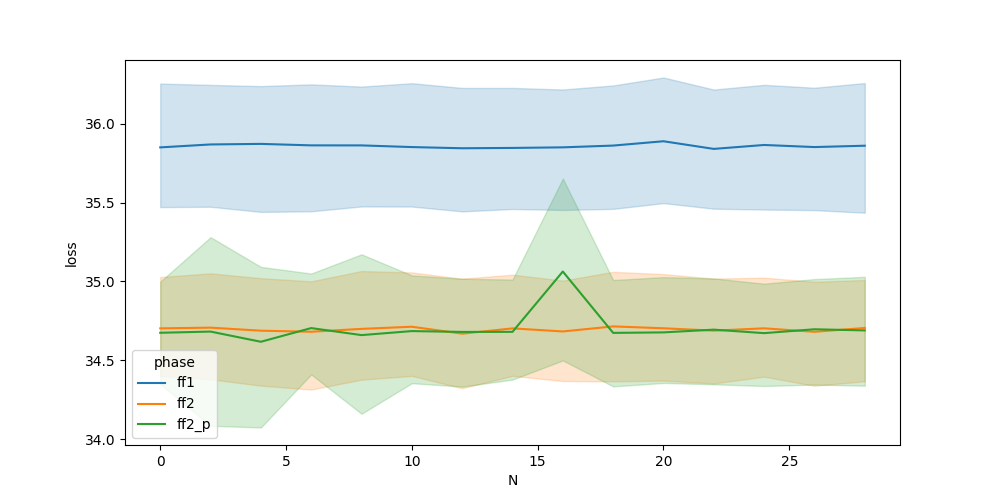

In [8]:
%matplotlib widget

fig,ax = plt.subplots(1,1,figsize=(10,5))

ax = sb.lineplot(x='N',y='loss',data=T,hue='phase')



T-statistic: 2.4109330903470116
P-value: 0.02620194131129869


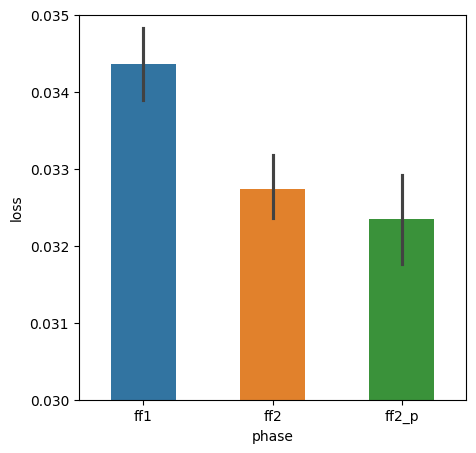

In [21]:
fig,ax = plt.subplots(1,1,figsize=(5,5))

ax = sb.barplot(x='phase',y='loss',data=T,hue='phase',width=0.5)

#ax.set_ylim([33,37])
ax.set_ylim([0.03,0.035])
#ax.set_ylim([14,16])

L = T.pivot_table(index='m',columns='phase',values='loss')
t_statistic, p_value = stats.ttest_rel(L['ff2'],L['ff2_p'])
print("T-statistic:", t_statistic)
print("P-value:", p_value)

In [20]:
t_statistic, p_value = stats.ttest_rel(T['ff2'],T['ff2_p'])

In [38]:
t_statistic, p_value = stats.ttest_rel(T['ff1'],T['ff2'])
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: 0.927251732376347
P-value: 0.3654257640171489
